In [158]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import TFDistilBertForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TFGPT2ForSequenceClassification, GPT2Config
from transformers import TFTrainingArguments, TFTrainer

In [159]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = 'intents.json'

intents = load_json_file(filename)

In [160]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = create_df()
df

,Pattern,Tag


In [161]:
def extract_json_info(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,How are you?,greeting
2,Is anyone there?,greeting
3,Hello,greeting
4,Good day,greeting


In [162]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "Chatbot")

Chatbot dataset has 405 rows and 2 columns


In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 0 to 404
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  405 non-null    object
 1   Tag      405 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [164]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 38 classes


In [165]:
df.isnull().sum()

Pattern    0
Tag        0
dtype: int64

In [166]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

C:\Users\yatch\AppData\Local\Temp\ipykernel_10652\1755447801.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)


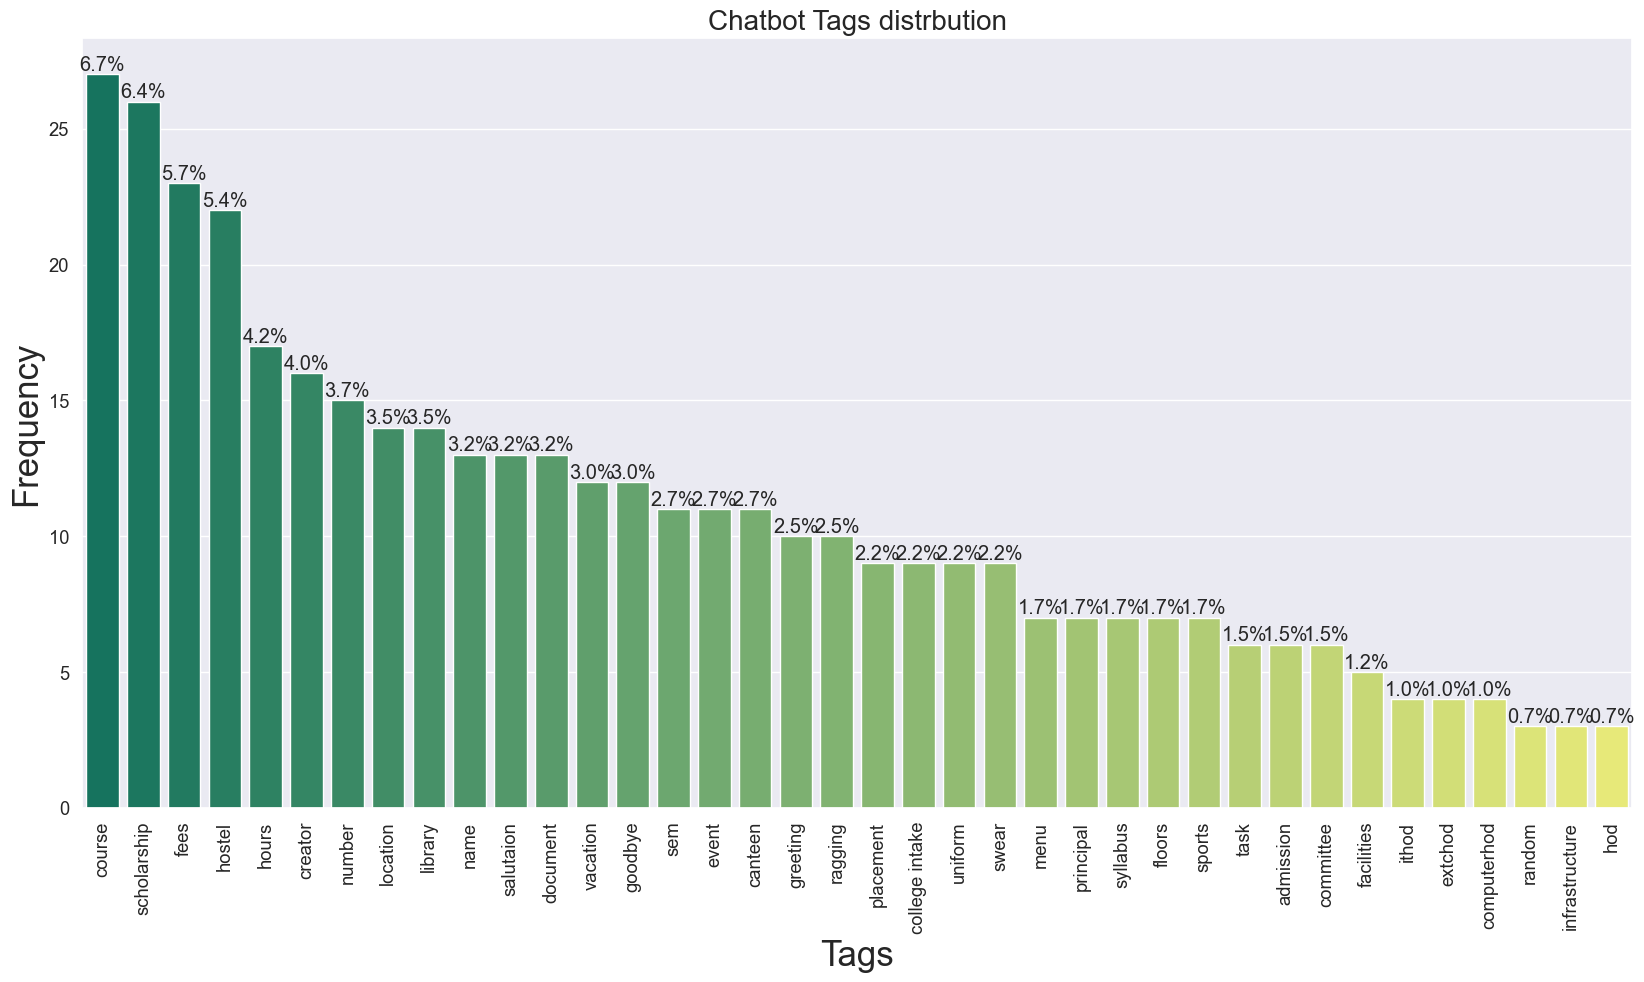

In [167]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [168]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)  

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)
df.head()

,Pattern,Tag
0,hi,greeting
1,how are you,greeting
2,is anyon there,greeting
3,hello,greeting
4,good day,greeting


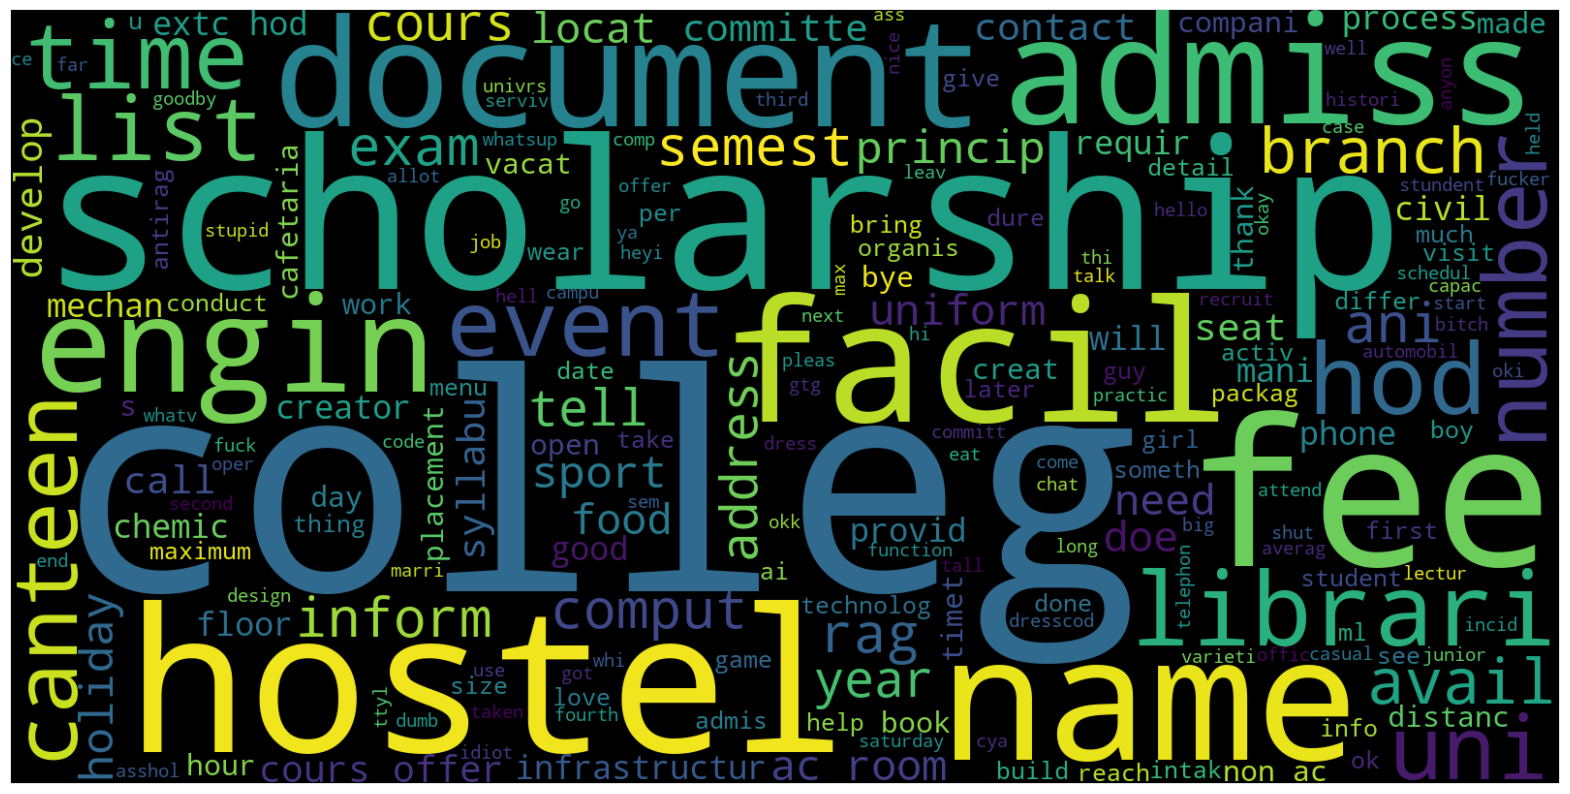

In [169]:
plt.figure(figsize=(20, 20)) 
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

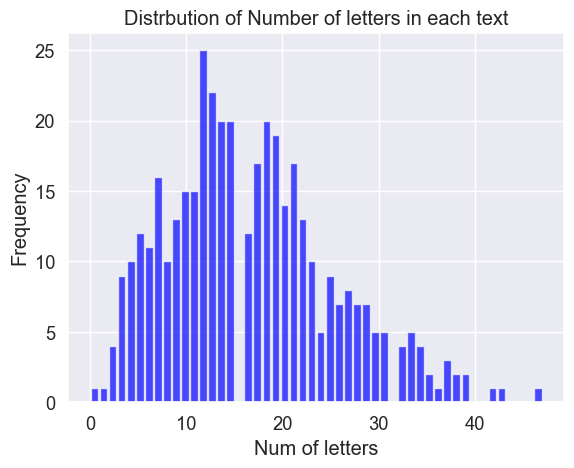

In [170]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='blue',bins=50, alpha=0.7, rwidth=0.85)
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

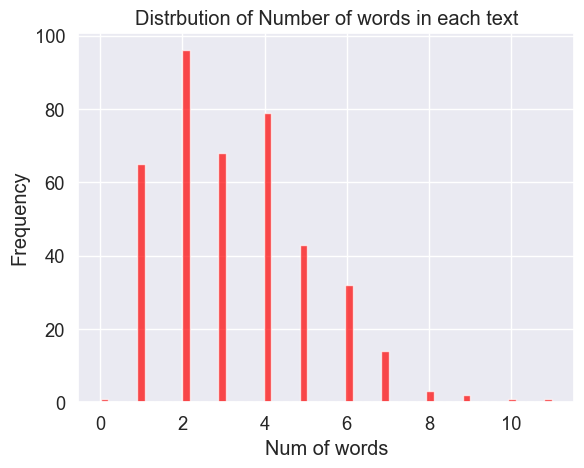

In [171]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='red',bins=50, alpha=0.7, rwidth=0.85)
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\yatch\AppData\Local\Temp\ipykernel_10652\3841709485.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,color='red')


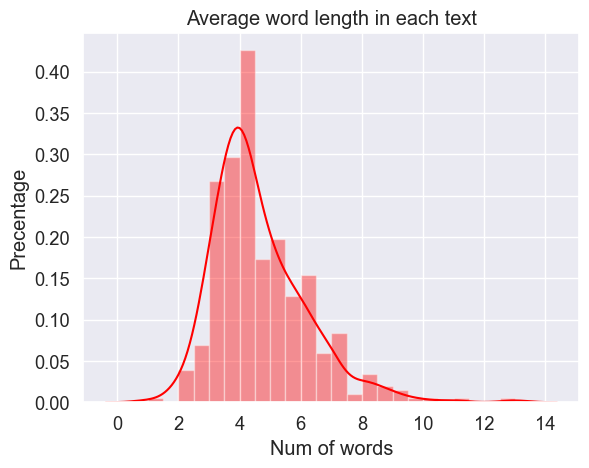

In [172]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [173]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['hi', 'how', 'are', 'you', 'is']

In [174]:
print(f"dataset contains {len(corpus)} words")

dataset contains 1345 words


In [175]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'is': 75,
 'colleg': 71,
 'what': 59,
 'the': 46,
 'you': 35,
 'of': 33,
 'in': 29,
 'for': 26,
 'scholarship': 26,
 'are': 25}

In [176]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

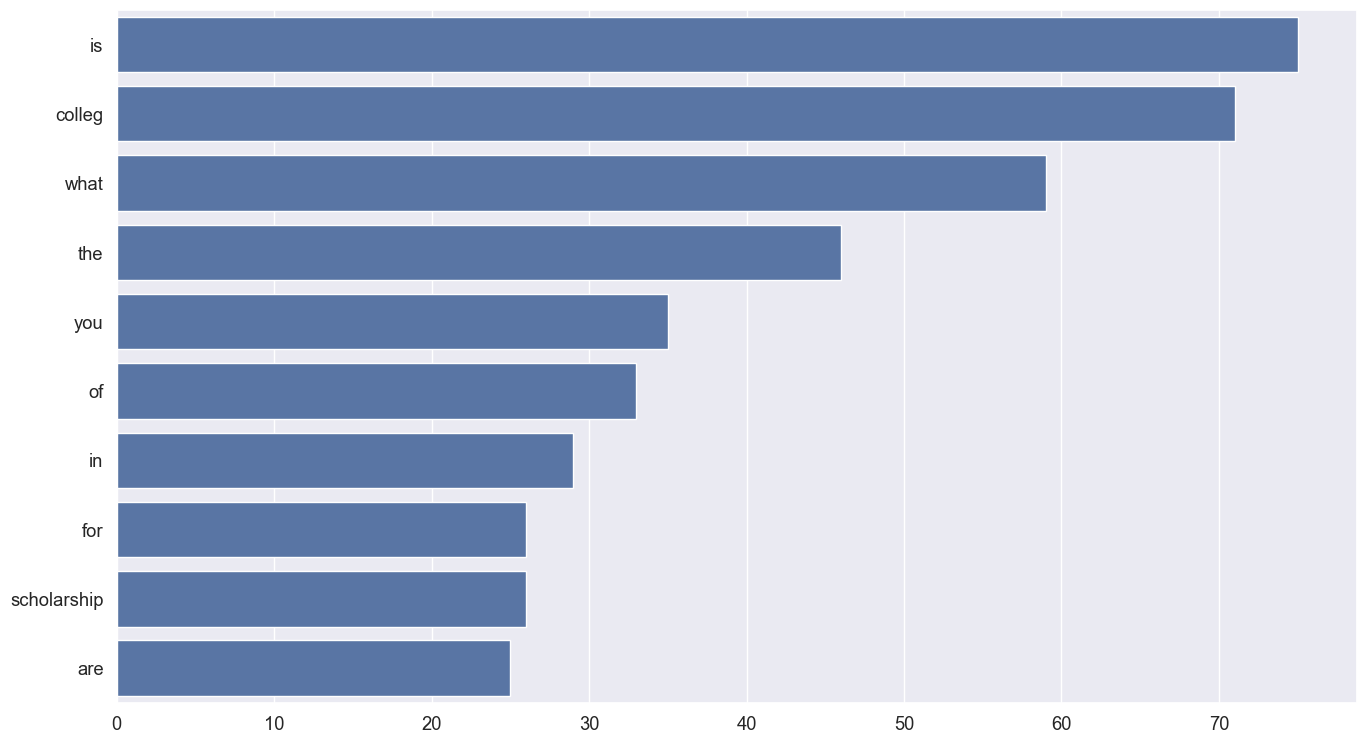

In [177]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

In [178]:
labels = df['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['greeting',
 'goodbye',
 'creator',
 'name',
 'hours',
 'number',
 'course',
 'fees',
 'location',
 'hostel',
 'event',
 'document',
 'floors',
 'syllabus',
 'library',
 'infrastructure',
 'canteen',
 'menu',
 'placement',
 'ithod',
 'computerhod',
 'extchod',
 'principal',
 'sem',
 'admission',
 'scholarship',
 'facilities',
 'college intake',
 'uniform',
 'committee',
 'random',
 'swear',
 'vacation',
 'sports',
 'salutaion',
 'task',
 'ragging',
 'hod']

In [179]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [180]:
id2label

{0: 'greeting',
 1: 'goodbye',
 2: 'creator',
 3: 'name',
 4: 'hours',
 5: 'number',
 6: 'course',
 7: 'fees',
 8: 'location',
 9: 'hostel',
 10: 'event',
 11: 'document',
 12: 'floors',
 13: 'syllabus',
 14: 'library',
 15: 'infrastructure',
 16: 'canteen',
 17: 'menu',
 18: 'placement',
 19: 'ithod',
 20: 'computerhod',
 21: 'extchod',
 22: 'principal',
 23: 'sem',
 24: 'admission',
 25: 'scholarship',
 26: 'facilities',
 27: 'college intake',
 28: 'uniform',
 29: 'committee',
 30: 'random',
 31: 'swear',
 32: 'vacation',
 33: 'sports',
 34: 'salutaion',
 35: 'task',
 36: 'ragging',
 37: 'hod'}

In [181]:
label2id

{'greeting': 0,
 'goodbye': 1,
 'creator': 2,
 'name': 3,
 'hours': 4,
 'number': 5,
 'course': 6,
 'fees': 7,
 'location': 8,
 'hostel': 9,
 'event': 10,
 'document': 11,
 'floors': 12,
 'syllabus': 13,
 'library': 14,
 'infrastructure': 15,
 'canteen': 16,
 'menu': 17,
 'placement': 18,
 'ithod': 19,
 'computerhod': 20,
 'extchod': 21,
 'principal': 22,
 'sem': 23,
 'admission': 24,
 'scholarship': 25,
 'facilities': 26,
 'college intake': 27,
 'uniform': 28,
 'committee': 29,
 'random': 30,
 'swear': 31,
 'vacation': 32,
 'sports': 33,
 'salutaion': 34,
 'task': 35,
 'ragging': 36,
 'hod': 37}

In [182]:
df['labels'] = df['Tag'].map(lambda x: label2id[x.strip()])
df.head()

,Pattern,Tag,labels
0,hi,greeting,0
1,how are you,greeting,0
2,is anyon there,greeting,0
3,hello,greeting,0
4,good day,greeting,0


In [183]:
X = list(df['Pattern'])
X[:5]

['hi', 'how are you', 'is anyon there', 'hello', 'good day']

In [184]:
y = list(df['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [185]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.2,random_state = 42)

In [186]:
model_name = "gpt2"
max_len = 256

tokenizer = GPT2Tokenizer.from_pretrained(model_name, 
                                          max_length=max_len)

model = TFGPT2ForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id = label2id)

All PyTorch model weights were used when initializing TFGPT2ForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFGPT2ForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [187]:
tokenizer.pad_token = tokenizer.eos_token
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [188]:
full_data = tokenizer(X, truncation=True, padding=True)

In [189]:
def convert_to_tf_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset

train_dataset = convert_to_tf_dataset(train_encoding, y_train)
test_dataset = convert_to_tf_dataset(test_encoding, y_test)

In [190]:
batch_size = 16
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [191]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Unbatch the dataset
train_dataset_unbatched = train_dataset.unbatch()

# Apply padding
# Apply padding
train_inputs = []
train_masks = []
for item in train_dataset_unbatched:
    input_ids = item[0]['input_ids']
    attention_mask = item[0]['attention_mask']
    
    # Ensure input_ids and attention_mask are lists
    if not isinstance(input_ids, list):
        input_ids = [input_ids]
    if not isinstance(attention_mask, list):
        attention_mask = [attention_mask]
    
    train_inputs.append(pad_sequences(input_ids, maxlen=256, truncating='post', padding='post'))
    train_masks.append(pad_sequences(attention_mask, maxlen=256, truncating='post', padding='post'))

# Convert lists to tf.data.Dataset
train_inputs_dataset = tf.data.Dataset.from_tensor_slices(train_inputs)
train_masks_dataset = tf.data.Dataset.from_tensor_slices(train_masks)

# Zip the datasets together
train_dataset_padded = tf.data.Dataset.zip((train_inputs_dataset, train_masks_dataset))

# Batch the dataset
train_dataset_padded = train_dataset_padded.batch(32)

In [195]:
def reshape_attention_mask(ds):
    input_ids, attention_mask = ds
    attention_mask = tf.reshape(attention_mask, (tf.shape(attention_mask)[0], 1, 1, tf.shape(attention_mask)[1]))
    return input_ids, attention_mask

# Apply the function to your datasets
train_dataset_padded = train_dataset_padded.map(reshape_attention_mask)


TypeError: in user code:


    TypeError: tf__reshape_attention_mask() takes 1 positional argument but 2 were given


In [192]:
def compute_metrics(true_labels, predictions):
    preds = predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='macro')
    acc = accuracy_score(true_labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [193]:
model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy(name="accuracy")]
)

In [194]:
callbacks = [
    ModelCheckpoint(filepath='./results/best_model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=3),
    TensorBoard(log_dir='./multi-class-logs')
]

history = model.fit(
    train_dataset_padded,  # Ensure dataset is batched
    validation_data=test_dataset.batch(16),
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100


3/3 [==============================] - ETA: 0s - loss: 10.2039 - accuracy: 1.9290e-04  

InvalidArgumentError: Graph execution error:

Detected at node 'tfgpt2_for_sequence_classification_4/transformer/Reshape_1' defined at (most recent call last):
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 542, in dispatch_queue
      await self.process_one()
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 531, in process_one
      await dispatch(*args)
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 775, in execute_request
      reply_content = await reply_content
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\yatch\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\yatch\AppData\Local\Temp\ipykernel_10652\3551280595.py", line 7, in <module>
      history = model.fit(
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1791, in fit
      val_logs = self.evaluate(
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\modeling_tf_utils.py", line 1748, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\modeling_tf_utils.py", line 1060, in run_call_with_unpacked_inputs
      r"""
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 1071, in call
      transformer_outputs = self.transformer(
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\modeling_tf_utils.py", line 1060, in run_call_with_unpacked_inputs
      r"""
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 383, in call
      if attention_mask is not None:
    File "c:\Users\yatch\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\models\gpt2\modeling_tf_gpt2.py", line 390, in call
      attention_mask = tf.reshape(attention_mask, (attention_mask_shape[0], 1, 1, attention_mask_shape[1]))
Node: 'tfgpt2_for_sequence_classification_4/transformer/Reshape_1'
Input to reshape is a tensor with 3840 values, but the requested shape has 256
	 [[{{node tfgpt2_for_sequence_classification_4/transformer/Reshape_1}}]] [Op:__inference_test_function_108983]

In [ ]:
eval_results = model.evaluate(test_dataset.batch(16))
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")

In [ ]:
def predict(text):
    
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [ ]:
text = "Hello"
predict(text)

In [ ]:
model_path = "chatbot"
model.save_model(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
model_path = "chatbot"


model = TFGPT2ForSequenceClassification.from_pretrained(model_path)
tokenizer= GPT2Tokenizer.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
chatbot("Hello")

In [ ]:
def chat(chatbot):
    
    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")
    
    text = input("User: ").strip().lower()
    
    while(text != 'quit'):

        score = chatbot(text)[0]['score']
        
        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue
        
        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])
        
        print(f"Chatbot: {response}\n\n")
            
        text = input("User: ").strip().lower()

In [ ]:
chat(chatbot)